Mini-projet : Interpolation de Données Manquantes
==============================

*Contexte* : dans le cadre d'acquisition de données sismiques, des capteurs (récepteurs) sont positionnés le long d'une ligne à la surface de la terre. Chacun enregistre au cours du temps le déplacement des particules (signal oscillant) qui varie lors du passage d'une onde acoustique ou élastique. Cet enregistrement s'appelle une **trace**. Chaque trace correspond à une *colonne* de l'image presentée au début de la section 2 (une seule position spatiale, un signal qui dépend du temps).

En pratique, il arrive que certains capteurs sont défaillants ou encore qu'ils ne sont pas présents dans certaines zones (pour des problèmes d'accessibilité par exemple). L'objectif principal du mini-projet est de reconstituer les traces manquantes.

*Hypothèses* : nous ferons l'hypothèse importante que les **signaux d'une trace peuvent être *localement* prédits à partir d'une trace voisine, par un simple décalage temporel** (voir la partie "Première Analyse" pour une définition précise). 

*Notions abordées* : 
* Analyse des signaux dans le domain d'origine ;
* Analyse des signaux après transformée de Fourier 2d ;
* Régularisation et formulation sous forme de problème inverse.

Pour cela, trois approches sont considerées :
* *Approche 1* : analyse dans le domaine $(x,t)$ : identification de 3 temps et de 3 pentes, sélection d'une ondelette source, prédiction des données manquantes ;
* *Approche 2* : transformée de Fourier 2d, identification des événements principaux, définition d'un masque et reconstitution des traces manquantes ;
* *Approche 3* (optionelle) : suite de l'approche 2 pour s'assurer que la prédiction respecte bien les observables. Elle se fait au travers de la résolution d'un problème inverse avec ajout de régularisation.

*Attentes* :
* Développement des approches 1 et 2 sur des données fournies ici ;
* Discusssion sur une comaparaison entre les approches 1 et 2, en particulier sur les avantages et limites des approches. Application de l'approche 1 ou 2 sur un exemple que vous pourrez créer vous-mêmes.

*Consignes* :
* **Très important** : pour toutes les figures, bien indiquer les axes avec les bonnes unités et des labels lisibles ;
* L'approche 3 est optionnelle.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Only for question 4 (optional)
from scipy.optimize import minimize

**Lecture des données**

In [67]:
# Labelsize (display)
labelsize   = 14
    
# Load the input data
# Input data (with missing traces)
gpanel = np.load('gpanel.npy')
# Dense data (with all traces, only for comparison)
panel_dense = np.load('panel_dense.npy')
nt, nx = gpanel.shape
print("Dimension des panneaux (axes temps et espace):",nt,nx)

# Missing traces (index number)
mtr = [2,5,6,11,12,20,21,22,23]

# Vertical axis -- time
dt   = 3.125e-3  # increment (s)
at   = np.linspace(0,dt*(nt-1),nt)
# Horizontal axis -- space
dx   = 10. # increment (m)
ax   = np.linspace(0,dx*(nx-1),nx)

Dimension des panneaux (axes temps et espace): 400 30


**Affichage des données**

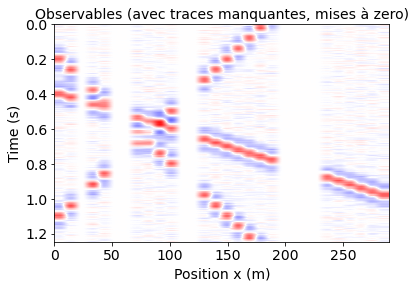

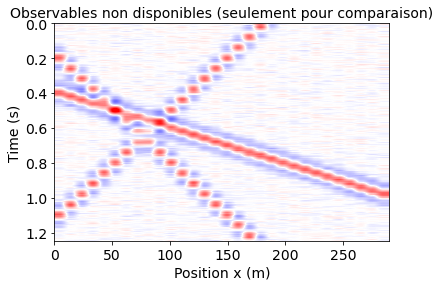

In [3]:
# Display of the input data
vmax = np.max(np.abs(gpanel))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(panel_dense,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables non disponibles (seulement pour comparaison)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

# Première Analyse
* Dans les 2 images plus haut, 3 événements principaux ressortent. Ils sont associés à 3 temps différents (pour $x = 0$ m) et à 3 pentes différentes représentées ici :

<img src="data.png" width="400">

* Nous ferons l'hypothèse que ces événements sont linéaires, c'est-à-dire qu'il est possible de prédire une trace à une position $x$ connaissant les temps $t_i$ à la position $x_0 = 0$ m, les pentes $p_i$ et une fonction $S(t)$ appelee ondelette source  :
$$u(t,x) \simeq \sum_{i=1}^{3} S(t - t_i - p_i(x-x_0))$$

* Quelle est l'unité des pentes $p_i$? Donner les valeurs approximatives de ces 3 pentes $p_i$ et des 3 temps $t_i$.

**Réponse**

La pente est en $s.m^{-1}$. Le signe de la pente est déterminé par le signe de l'angle formé par la flèche représentée sur la figure.

Calcul de $p_1$ : $-\frac{1-0.4}{300-0} = - 2,0 \ ms.m^{-1}$.

Calcul de $p_2$ : $-\frac{1.1-0}{0-180} = 6,1 \ ms.m^{-1}$.

Calcul de $p_3$ : $-\frac{1.2-0.2}{170-0} = - 5,9 \ ms.m^{-1}$.

On a approximativement $t_1 = 0.4s$, $t_2 = 1.1s$ et $t_3 = 0.2s$.



**Aliasing spatial**

Sur l'image suivante, des événements sont visibles à gauche, avec une pente bien visible $p_1$. Sur la partie de droite de l'image, deux pentes sont identifiables $p_2$ et $p_3$. Pourtant on peut suivre des événement de gauche à droite : c'est l'effet d'aliasing spatial.

<img src="aliasing.png" width="400">

Construisez des données comme suit, avec les mêmes échantillonages temporel et spatial que sur l'exemple avec les données manquantes : 
$$d(t,x) = \sin(2 \pi f_c (t - p\cdot x))$$
$f_c$ est la fréquence caractéristique du signal (pour l'obtenir, calculer les spectres de plusieurs traces et déterminer $f_c$ comme valeur pour laquelle le spectre est en moyenne le plus grand). Tracer $d(t,x)$ pour différentes valeurs de $p$, en commençant par $p=0$. La pente visible dans les données augmente avec $p$, jusqu'à un certain moment : c'est l'effet d'aliasing spatial. Est-il possible de retrouver le cas $p=0$ pour un $p$ non nul? A partir des observations, proposer un critère à respecter pour éviter l'aliasing spatial. Ce critère est une relation entre $p$, $f_c$ et la distance $dx$ (ici 10 m) entre 2 traces consécutives. Vérifier si les pentes $p_i$ conduisent ou pas à de l'aliasing spatial.

Fréquence fc : 8.799999999999999


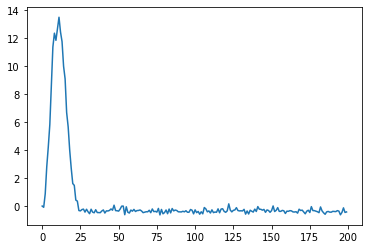

In [4]:
# Calcul des transformées de Fourier pour chaque x
transformees = np.fft.fft(gpanel, axis=0)[0:nt//2,:]
transformees = np.abs(transformees)
# Calcul des moyennes pour chaque fréquence
transformees_mean = np.mean(transformees - transformees[0,:], axis=1) 
# fc est la fréquence pour laquelle la moyenne est maximale
indice = np.argmax(transformees_mean)
fc = indice/nt/dt
print(f"Fréquence fc : {fc}")
# on verifie graphiquement
plt.plot(transformees_mean)
plt.show()

In [5]:
def d(t, x, fc, p):
    return np.sin(2*np.pi*fc*(t-p*x))

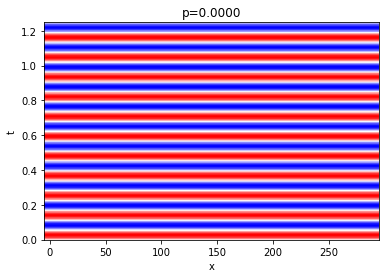

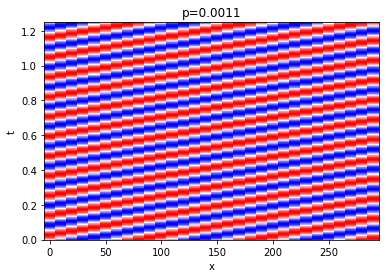

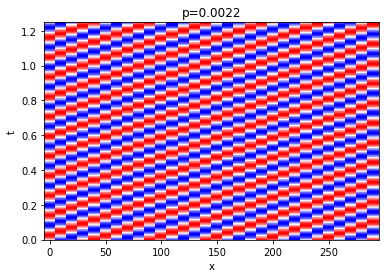

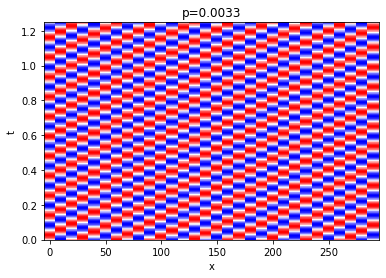

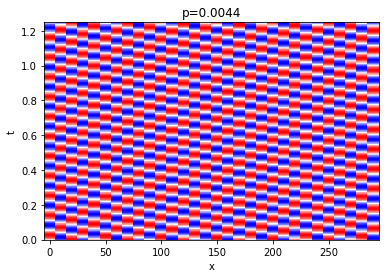

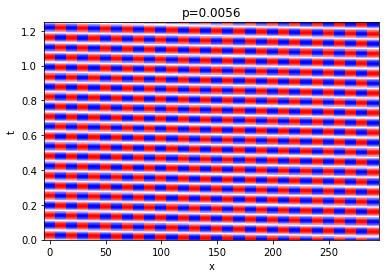

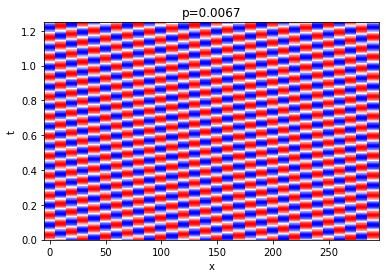

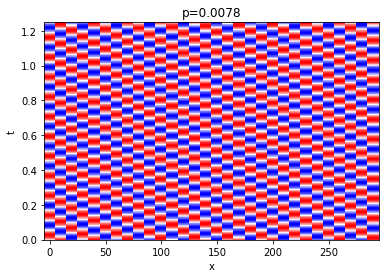

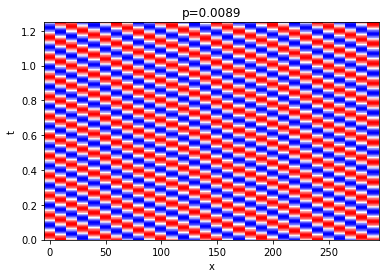

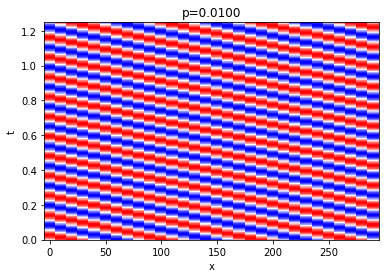

In [6]:
X, T = np.meshgrid(ax, at)

for p in np.linspace(0, 0.01, 10):
    Z = d(T, X, fc, p)
    plt.pcolor(X, T, Z)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f"p={p:0.4f}")
    plt.show()

Pour retrouver le cas $p=0$, il faut que la contribution de $x$ dans le sinus soit un multiple de $2\pi$, c'est-à-dire $\forall x, f_cp x \in \mathbb{Z}$ avec tous les $x$ s'écrivant $n\times dx, n\in \mathbb{N}$.

Ainsi on retrouve le cas $p=0$ pour tout $p$ tel que $p = \frac{n}{f_c dx}, n\in \mathbb{N}$.

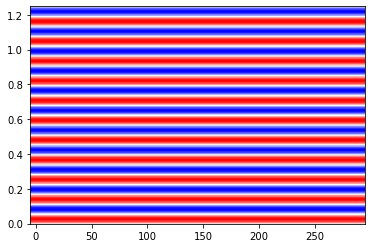

In [7]:
Z = d(T, X, fc, p=1/fc/dx)
plt.pcolor(X, T, Z)
plt.show()

Le critère de Shannon pour éviter le repliement spectral donne des conditions sur les fréquences spatiale et temporelle. 

$2f_{max, x} \leq f_e$ et $2f_{max, t} \leq f_e$.

La condition spatiale s'écrit $2f_cp \leq \frac{1}{dx}$ soit $$p≤\frac{1}{2f_cdx}$$

$$p≤\frac{1}{2\times 8.8\times 10}$$

$$p≤0.0058 s.m^{-1}$$

# Approche 1 : Reconstitution des Données dans le Domaine $(x,t)$

## Détermination de $S(t)$

Sélectionner une trace (par exemple pour $x$ autour de 250 m et déterminer $S(t)$ avec l'hypothèse que $S(t)$ est maximale pour $t=0$. Prendre pour le support de $S$ une fenêtre de longueur autour de 0.2 s. Afficher le résultat.

On a pour $x = 250m$, $u(x,t)=S(t)$.

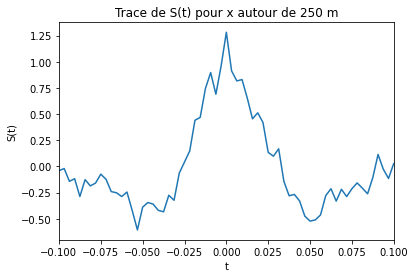

In [8]:
ind_x = int(250/dx)
S = gpanel[:,ind_x]
# On recentre S pour qu'elle soit maximale en t=0
T0 = np.argmax(S)
plt.plot(at-T0*dt, S)
plt.xlim(-0.1, 0.1)
plt.xlabel('t')
plt.ylabel('S(t)')
plt.title('Trace de S(t) pour x autour de 250 m')
plt.show()

## Détermination des $(t_i,p_i)$

A partir de la première trace en $x_0=0$, calculer pour plusieurs temps et pour plusieurs pentes les sommations suivantes :

$$F(t,p) = \Bigg[\int \,u(t-p\cdot(x-x_0),x)\,dx\Bigg]^2$$

A quoi correspondent les maxima de $F$? En déduire les valeurs de $(t_i,p_i)$ pour $i\in[1,3]$. Bien choisir l'échantillonnage en temps et en pente pour une bonne détermination des $(t_i,p_i)$. 

Remarques :
* Par exemple, il peut être intéressant d'interpoler linéairement entre 2 points voisins si $t - p\cdot(x-x_0)$ ne tombe pas sur un point de grille ;
* Pour une bonne estimation, l'échantillonnage des pentes doit être suffisament fin ;
* Il est possible de reprendre une idée du TP "synthèse musicale" pour sélectionner itérativement les meilleurs $(t_i,p_i)$, mais ici en 2d.

Reconstruire les données à partir de l'équation (1) et des valeurs $(t_i,p_i)$ sélectionnées. Commentez les résultats.

**Réponse**

$(t,x) \mapsto u(t-p(x-x_0), x)$ est l'expression d'une onde progressive. Celle-ci est maximale en un point $(x, t)$ lorsqu'une onde sismique passe par ce point. Les maxima de $F$ correspondent donc à une onde progressive qui coïncide avec l'onde sismique.

Il existe donc trois maxima de $F$ correspondant à trois couples $(t_i, p_i)$. Vérifions cela numériquement. Il faut s'assurer que les points sélectionnés ne sont pas sur le même pic.

On commence par définir les paramètres d'échantillonnage et la fonction $F$.

In [9]:
# échantillons
nt_samples = 200
np_samples = 200
pentes_samples = np.linspace(-1e-2, 1e-2, np_samples)
time_samples = np.linspace(0, 1.2, nt_samples)

# fonction F
x0 = 0
def F(t, p, x0=x0, gpanel=gpanel):
    res = 0
    for n in range(nx):
        t_F = t - p*(n*dx - x0)
        #on vérifie que t_F est dans l'intervalle
        if t_F >= 0 and t_F < 1.2:
            res += gpanel[int(t_F/dt), n]*dx
    return res**2

Pour éviter des calculs répétitifs, on stocke toutes les valeurs de $F$ dans un tableau.

In [10]:
F_array = np.zeros((nt_samples, np_samples))
for i in range(nt_samples):
    for j in range(np_samples):
        F_array[i, j] = F(time_samples[i], pentes_samples[j])


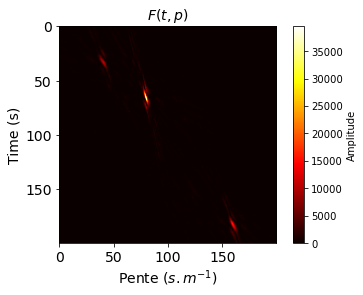

In [11]:
# Affichage de F
vmax = np.max(F_array)
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(F_array, cmap='hot')
plt.title('$F(t,p)$', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Pente ($s.m^{-1}$)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
cbar = plt.colorbar()
cbar.set_label("Amplitude")

On constate en effet qu'il y a $3$ taches prenant des valeurs plus élevées. Il faut désormais identifier ces 3 points.

Le raisonnement est le suivant :

On va chercher dans les 3 zones qui se distinguent par leur couleur le maximum sur chaque zone. Le problème est d'identifier les zones identifiées. On imagine qu'en quadrillant l'espace, et en cherchant sur chaque carré le maximum, on pourra trouver les points qui nous intéressent.

On définit ici le maximum au sens strict : si la zone est uniforme il n'y a pas de maximum. C'est cette définition qui nous permet de régler le problème des maxima trouvés sur les zones sombres qui ne nous intéressent pas.

On uniformise toutes les valeurs en-dessous de $5 000$, qui ne nous intéressent pas, à $5 000$ (le choix de cette valeur est fait grâce àà l'échelle colorée).

Enfin on choisit une largeur de la zone (ech dans la fonction) suffisamment faible pour ne pas englober plusieurs taches, mais suffisamment grande pour englober l'entièreté de chaque tache. Sur chaque zone, on obtient le maximum et sa valeur grâce à la fonction is_maximum.


In [55]:
# uniformisation des zones sombres
F_array = np.maximum(F_array, 5000)

# recherche du maximum au sens strict autour du point (i,j) avec une largeur de 20
def is_maximum(i, j, F_array, length=20):
    max_value = np.max(F_array[max(i-length, 0): min(i+length+1, nt_samples), max(j-length, 0): min(j+length+1, np_samples)])
    min_value = np.min(F_array[max(i-length, 0): min(i+length+1, nt_samples), max(j-length, 0): min(j+length+1, np_samples)])
    return F_array[i, j] == max_value and F_array[i, j] > min_value

epsilon = 10**(-2)
maxima_points = []
maxima_indices = []
maxima_values = []
for ind_t in range(nt_samples):
    for ind_p in range(np_samples):
        if is_maximum(ind_t, ind_p, F_array):
            maxima_points.append((time_samples[ind_t], pentes_samples[ind_p]))
            maxima_values.append(F_array[ind_t, ind_p])
            maxima_indices.append([ind_t, ind_p])

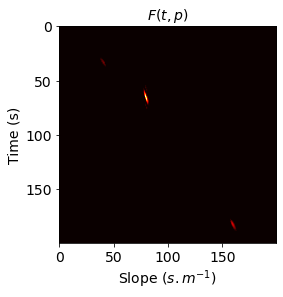

In [56]:
# Affichage du résultat
vmax = np.max(F_array)
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(F_array, cmap='hot')
plt.title('$F(t,p)$', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Slope ($s.m^{-1}$)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)

t1, p1 = maxima_points[0]
t2, p2 = maxima_points[1]
t3, p3 = maxima_points[2]

On retrouve les valeurs des pentes trouvées précédemment, ce qui appuie nos résultats.

In [57]:
for i, (t, p) in enumerate(maxima_points):
    print(f'(t{i+1}, p{i+1}) = ({round(t, 1)}, {round(p, 4)})')

(t1, p1) = (0.2, -0.006)
(t2, p2) = (0.4, -0.0021)
(t3, p3) = (1.1, 0.006)


Reconstituons les valeurs manquantes dans gpanel. L'équation de chaque droite est donc donnée par :
$t = t_i - p_i\times x$.

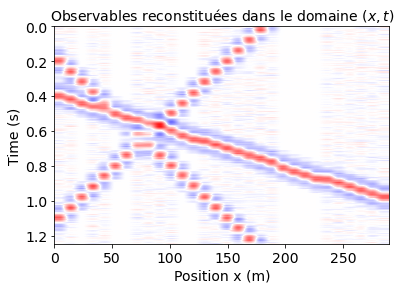

In [58]:
# Reconstitution
gpanel_reconst = np.copy(gpanel)
borne = 30
for i, m in enumerate(mtr):
    for j in range(3):
        t, p = maxima_points[j]
        ind_t = round((t - p*m*dx)/dt)
        for eps in range(borne):
            if ind_t + eps < nt and ind_t + eps >= 0:
                gpanel_reconst[ind_t + eps, m] = gpanel[min(nt - 1, round(t/dt+eps)), 0]
            if ind_t - eps >= 0 and ind_t - eps < nt:
                gpanel_reconst[ind_t - eps, m] = gpanel[max(0, round(t/dt-eps)),0]
                
# Affichage
vmax = np.max(np.abs(gpanel_reconst))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel_reconst,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables reconstituées dans le domaine $(x, t)$', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

**Commentaires**

En dehors des droites, les valeurs prises par gpanel sont théoriquement nulles mais en pratique contiennent du bruit. Nous laissons donc à $0$ les valeurs hors des droites pour les parties reconstituées.

On se place ensuite dans un intervalle $[ - borne, borne]$ autour du centre de la droite pour reconstituer les valeurs aux abscisses manquantes, borne étant un paramètre choisi arbitrairement.

**Observations**

Pour rappel, voici le résultat attendu :

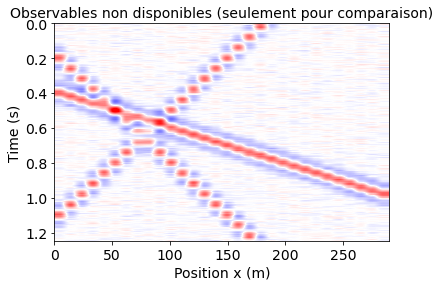

In [16]:
vmax = np.max(np.abs(gpanel))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(panel_dense,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables non disponibles (seulement pour comparaison)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

Le résultat correspond bien à celui souhaité. L'étude est donc satisfaisante.

On observe un léger décalage dans la partie reconstituée, surtout entre les abscisses $20$ et $25$ puisque c'est la partie manquante la plus large. Cela est sans doute dû à une imprécision de l'ordonnée à l'origine obtenue précédemment.

# Approche 2 : Analyse des Données dans le Domaine de Fourier 2d

## Approche théorique
Calculer la transformée de Fourier 2d de $u$ à partir de la transformée de Fourier 1d de $S$. Expliquer toujours à partir des équations pourquoi on s'attend à avoir 3 événements linéaires dans le domaine de Fourier. Pourquoi tous ces événements passent-ils par l'origine $(0,0)$ dans le domaine de Fourier? Donner une expression quantitative entre les pentes dans le domaine de Fourier et les pentes $p_i$. 

## Implémentation
Représenter la transformée de Fourier 2d et bien préciser les axes. Indiquer à quoi correspondent la fréquence maximale et le nombre d'onde maximal. Faire le lien entre les 3 événements dans l'espace $(t,x)$ et ceux dans l'espace de Fourier. Expliquer ce qu'il se passe aux bords dans le domaine de Fourier. N'hesitez pas à zoomer autour de la position centrale dans le domaine de Fourier.

Remarques : 
* Le nombre d'onde (en 1/m) est l'équivalent de la fréquence pour l'axe spatial ;
* Le signal a très peu d'énergie pour les fréquences au-delà de 20 Hz. 

### Approche théorique

**Calcul de la transformée de Fourier $2$d de u**

On reprend l'approximation : $$u(t,x) \simeq \sum_{i=1}^{3} S(t - t_i - p_i(x-x_0)).$$

On a alors :

\begin{align*}
F(u)(\omega, \Omega)
    &= \iint u(x,t) e^{-i(\omega t +\Omega x)} dx dt\\
    &= \iint \sum_{i=1}^3 S(t-t_i-p_i(x-x_0))e^{-i\omega t} e^{-i\Omega x} dt \ dx \\
    &= \sum_{i=1}^3 \iint S(t-p_ix)e^{-i\omega (t+t_i)}e^{-i \Omega (x + x_0)} dt \ dx \text{ par changements de variable } x\leftarrow x-x_0 \text{ et } t \leftarrow t-t_i\\
    &=  e^{-i \omega t_i} e^{-i \Omega x_0}\sum_{i=1}^3 \iint S(t-p_ix)e^{-i\omega t}e^{-i \Omega x} dt \ dx \\
    &= e^{-i \omega t_i} e^{-i \Omega x_0}\sum_{i=1}^3 \iint S(t-p_ix)e^{-i\omega (t-p_ix)} dt e^{i \omega p_ix} e^{-i \Omega x} dx \\
    &= e^{-i \omega t_i} e^{-i \Omega x_0}\sum_{i=1}^3 \iint S(u)e^{-i\omega (u)} du e^{i \omega p_ix} e^{-i \Omega x} dx \text{ par changement de variable } u \leftarrow t-p_ix \\
    &= e^{-i \omega t_i} e^{-i \Omega x_0}\sum_{i=1}^3 \int \mathcal{F}(S)(\omega) e^{i(\omega p_i - \Omega)x} dx \\
    &= e^{-i \omega t_i} e^{-i \Omega x_0}\sum_{i=1}^3 \mathcal{F}(S)(\omega) \int e^{i(\omega p_i - \Omega)x} dx \\
    &= \sum_{i=1}^3 e^{-i \omega t_i} e^{-i \Omega x_0} \mathcal{F}(S)(\omega) \mathcal{F}(\mathbb{1}_\mathbb{R})(\omega p_i - \Omega) \\
    &= \sum_{i=1}^3 e^{-i \omega t_i} e^{-i \Omega x_0} \mathcal{F}(S)(\omega) \delta (\omega p_i - \Omega) \text{ où } \delta \text{ et la fonction dirac} \\
\end{align*}

On voit donc que la transformée de Fourier de $u$ est nulle pour tout $(\omega, \Omega)$ tel que $\omega p_i \neq \Omega$ pour $i \in \{ 1,2, 3 \}$. On s'attend bien à observer $3$ droites.

On vérifie d'ailleurs que peu importent les valeurs des $p_i$, on aura toujours $0 \times p_i - 0 = 0$. Les droites passent donc bien par l'origine.

In [17]:
## problème valeurs des axes

Text(0.5, 0, 'Fréquence spatiale ($m^{-1}$)')

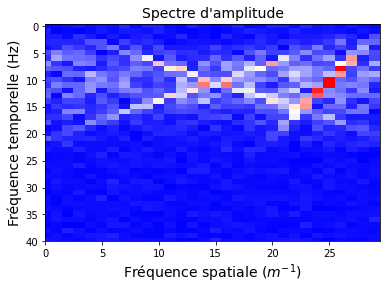

In [18]:
# Implémentation
# calcul de la transformée de fourier
gpanelf = np.fft.fft2(gpanel)
tf_final = np.abs(gpanelf)

# affichage de la transformée de Fourier
fig = plt.figure()
av = plt.subplot(111)

plt.imshow(tf_final,aspect='auto');

plt.title("Spectre d'amplitude", fontsize=labelsize)

# zoom
plt.ylim(40,)
plt.xlim(0,)

av.set_ylabel("Fréquence temporelle (Hz)", fontsize=labelsize)
av.set_xlabel("Fréquence spatiale ($m^{-1}$)", fontsize=labelsize)

Nous nous attendions à observer 3 événements dans le domaine de Fourier car on avait 3 événements majoritaires dans le domaine temporel.

Par linéarité de la transformée de Fourier, les événements dans le domaine fréquentiel (à la fois spatial et temporel) sont également linéaires.

Les fréquences spatiale et temporelle maximales représentent l'arrivée de l'onde sismique.

On retrouve bien des droites passant par l'origine (par périodicité du spectre, il suffit que les droites passent par l'origine ou par le coin en bas à droite du graphe ; on imagine bien que la trace à droite arrive aussi par les abscisses négatifs et passe donc par l'origine).

## Définition d'un masque dans le domaine de Fourier 2d
On note $f$ la fréquence et $k_x$ le nombre d'onde. Dans le domaine de Fourier 2d, on souhaite définir un masque avec des 1 qui couvrent les événements principaux. A partir de $(f,k_x)=(0,0)$, faire des sommations selon différentes pentes (dans le domaine de Fourier, après avoir pris le module des valeurs complexes) et tracer la valeur de ces sommes en fonction de la pente. On s'attend à ce que 3 valeurs ressortent. Calculer une fonction qui sélectionne automatiquement ces valeurs et construire un masque dans le domaine de Fourier 2d qui vaut 1 autour de ces trois valeurs principales et 0 en dehors.

Comment faire pour prendre en compte ce qui se passe aux bords dans le dommaine de Fourier?

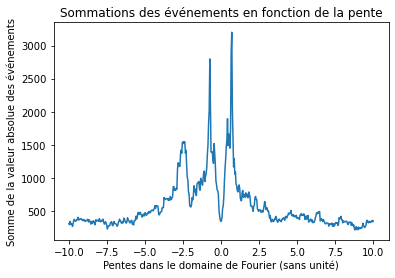

In [19]:
# échantillon de pentes possibles
pentes = np.linspace(-10, 10, 500)
gpanelf = np.abs(np.fft.fft2(gpanel))

def sommations(pente):
    somme = 0
    #on définit le sens de parcours
    if pente >= 0:
        sens = 1
        x0, t0 = 0, 0
    else:
        sens = -1
        x0, t0 = nx-1, 0
    #on part de (f, kx) = (0,0)
    x, t = x0, t0
    while (x < nx) and (x >= 0) and (t < nt) and (t >= 0):
        somme += gpanelf[t, x]
        x += sens
        t = round(t0 + pente*(x-x0))
    return somme

sommes = np.vectorize(sommations)(pentes)
plt.plot(pentes, sommes)
plt.title("Sommations des événements en fonction de la pente")
plt.xlabel("Pentes dans le domaine de Fourier (sans unité)")
plt.ylabel("Somme de la valeur absolue des événements")
plt.show()

On vérifie bien graphiquement que $3$ valeurs majoritaires ressortent.

Il reste à les isoler. Pour cela, on sépare en trois le domaine $[ -10, 10 ]$ de manière à isoler les $3$ maxima visibles, et on calcule le maximum sur chaque portion du domaine.

In [20]:
def max_sommations(borne_min, borne_max, plot=False):
    pentes = np.linspace(borne_min, borne_max, 500)
    sommes = np.vectorize(sommations)(pentes)
    indice = np.argmax(sommes)
    if plot:
        plt.plot(pentes, sommes)
        plt.title("Sommations des événements en fonction de la pente")
        plt.xlabel("Pentes dans le domaine de Fourier (sans unité)")
        plt.ylabel("Somme de la valeur absolue des événements")
        plt.show()
    return pentes[indice]

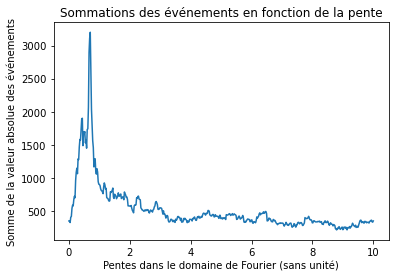

In [21]:
p1 = max_sommations(-10, -2)
p2 = max_sommations(-2, 0)
p3 = max_sommations(0, 10, plot=True)

In [22]:
print(p1, p2, p3)

-2.4168336673346698 -0.7374749498997997 0.7014028056112224


On retrouve bien deux valeurs environ opposées, mais pas tout à fait. Il y a donc sans doute quelques approximations dans ce raisonnement.

Les pentes calculées ici sont dépendantes des pas de temps et de distance $dt$ et $dx$. Comme pour le calcul de la fréquence de coupure, retrouvons les pentes correctes :

In [23]:
def conversion(pente_dom_fourier):
    return 1/((nx*dx)/(nt*dt)*pente_dom_fourier)

p1_reel = conversion(p1)
p2_reel = conversion(p2)
p3_reel = conversion(p3)
print(round(p1_reel, 4), round(p2_reel, 4), round(p3_reel, 4))

-0.0017 -0.0056 0.0059


On retrouve des pentes proches des valeurs trouvées dans les parties précédentes, mais pas tout à fait exactes.

Créons maintenant le masque.

In [24]:
def create_masque(gpanelf=gpanelf, pentes=[p1, p2, p3], length=1):
    masque = np.zeros(gpanelf.shape)
    # on réutilise la méthode précédente
    for pente in pentes:
        #on part de (f, kx) = (0,0)
        #on définit le sens de parcours
        if pente >= 0:
            sens = 1
            x0, t0 = 0, 0
        else:
            sens = -1
            x0, t0 = nx-1, 0
        x, t = x0, t0
        # le signal a très peu d'énergie au delà de 20 Hz
        while (x < nx) and (x >= 0) and (t < 20) and (t >= 0):
            # On se place dans un intervalle autour du point considéré
            masque[max(t-length, 0) : min(t+length+1, nt), max(x-length, 0) : min(x+length+1, nx)]= 1
            x += sens
            t = round(t0 + pente*(x-x0))
    return masque

masque = create_masque()

On obtient le masque suivant : 

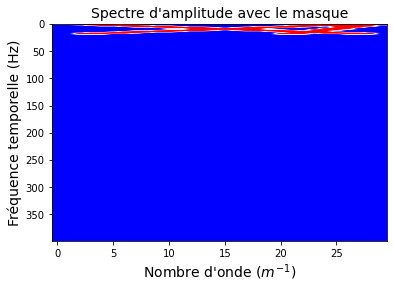

In [25]:
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(masque, aspect='auto')
plt.title("Spectre d'amplitude avec le masque", fontsize = labelsize)
av.set_ylabel("Fréquence temporelle (Hz)", fontsize = labelsize)
av.set_xlabel("Nombre d'onde ($m^{-1}$)", fontsize = labelsize);

En zoomant, pour y voir plus clair :

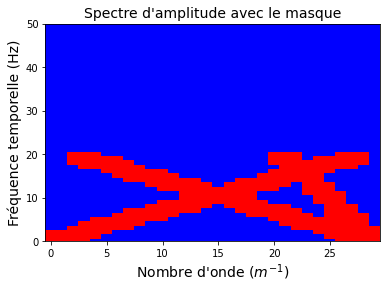

In [26]:
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(masque, aspect='auto')
plt.ylim(0, 50)
plt.title("Spectre d'amplitude avec le masque", fontsize = labelsize)
av.set_ylabel("Fréquence temporelle (Hz)", fontsize = labelsize)
av.set_xlabel("Nombre d'onde ($m^{-1}$)", fontsize = labelsize);

Pour rappel, ce masque sélectionne le signal suivant :

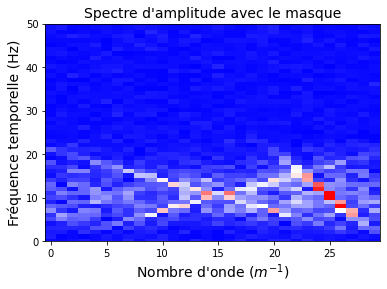

In [27]:
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(np.abs(gpanelf), aspect='auto')
plt.ylim(0, 50)
plt.title("Spectre d'amplitude avec le masque", fontsize = labelsize)
av.set_ylabel("Fréquence temporelle (Hz)", fontsize = labelsize)
av.set_xlabel("Nombre d'onde ($m^{-1}$)", fontsize = labelsize);

C'est donc tout à fait cohérent. Nous vérifions la cohérence par la suite.

## Application du masque et analyse des résultats
Appliquer le masque (sur les données après transformée de Fourier 2d, sans prendre le module des valeurs), puis appliquer la transformée de Fourier inverse. Commenter les résultats (comparaison à la fois dans les domaines $(t,x)$ et $(f,k_x)$. Si nécessaire, revenir à la question précédente pour changer le masque et avoir une meilleure interpolation des données. Expliquer ces changements. Discuter de l'importance du masque.

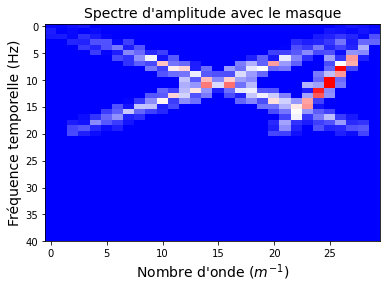

In [28]:
gpanelf = np.fft.fft2(gpanel)
gpanelf_masque = masque * gpanelf
gpanelf_masque_abs = np.abs(gpanelf_masque)

# Affichage
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanelf_masque_abs, aspect='auto')
plt.ylim(40,)
plt.title("Spectre d'amplitude avec le masque", fontsize = labelsize)
av.set_ylabel("Fréquence temporelle (Hz)", fontsize = labelsize)
av.set_xlabel("Nombre d'onde ($m^{-1}$)", fontsize = labelsize);

Lorsqu'on applique le masque dans le domaine de Fourier, les seuls points qui apparaissent sont ceux des directions principales. On a supprimé le bruit dans les autres zones.

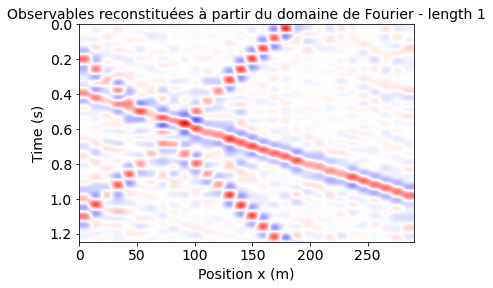

In [29]:
observables_masque = np.real(np.fft.ifft2(gpanelf_masque))

vmax = np.max(np.abs(observables_masque))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(observables_masque, extent=[ax[0],ax[-1],at[-1],at[0]], aspect='auto')
plt.title('Observables reconstituées à partir du domaine de Fourier - length 1', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

Pour rappel, les observables réelles sont :

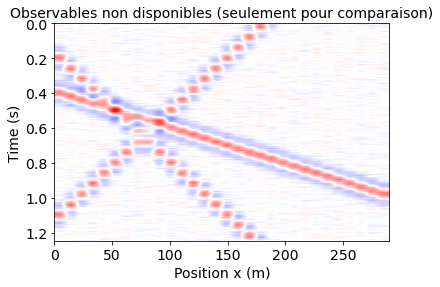

In [30]:
vmax = np.max(np.abs(panel_dense))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(panel_dense,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables non disponibles (seulement pour comparaison)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

**Commentaires**

On retrouve bien les traces recherchées. Le résultat est meilleur que celui de la première approche au niveau des droites reconstituées. En revanche le contraste est plus faible, et on observe un léger effet d'aliasing spatial non souhaité. Le masque pourrait sans doute être amélioré pour limiter cet effet. En conséquence, les signaux sont moins nets à cause du bruit important.

Le paramètre length choisi pour former le masque, c'est à dire la largeur de la zone autour du point de la droite choisie, a un impact important sur le résultat. Plus il est large plus le résultat sera contrasté mais moins la reconstitution sera visible. A l'inverse, si on reste en ce point, la droite est reconstituée mais peu contrastée, on observe également un repliement spectral qui ajoute des droites supplémentaires aux observables originelles.

Ainsi, en choisissant un échantillon plus grand :

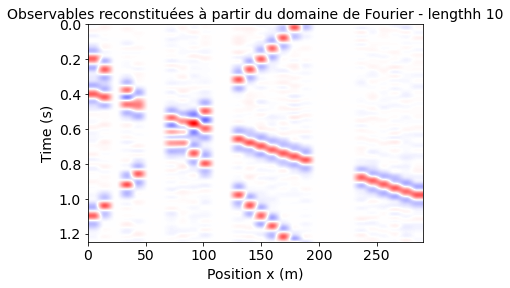

In [31]:
masque_faible = create_masque(length=10)
gpanelf = np.fft.fft2(gpanel)
gpanelfaible_masque = masque_faible * gpanelf
observables_faibles = np.real(np.fft.ifft2(gpanelfaible_masque))

vmax = np.max(np.abs(observables_faibles))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(observables_faibles, extent=[ax[0],ax[-1],at[-1],at[0]], aspect='auto')
plt.title('Observables reconstituées à partir du domaine de Fourier - lengthh 10', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

Et un échantillon plus petit :

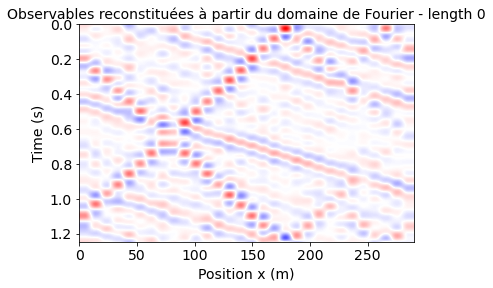

In [32]:
masque_fort = create_masque(length=0)
gpanelf = np.fft.fft2(gpanel)
gpanelfort_masque = masque_fort * gpanelf
observables_fortes = np.real(np.fft.ifft2(gpanelfort_masque))

vmax = np.max(np.abs(observables_fortes))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(observables_fortes, extent=[ax[0],ax[-1],at[-1],at[0]], aspect='auto')
plt.title('Observables reconstituées à partir du domaine de Fourier - length 0', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

La reproduction des signaux est bien meilleure, on ne voit plus la différence entre les parties originelles et les parties reconstituées, mais l'effet d'aliasing est beaucoup plus marqué et brouille les observables.

# Approche 3 : Amélioration de l'Approche 2 (*partie optionelle*)
Le résultat de l'approche 2 montre en pratique que les données prédites après transformée de Fourier inverse 2d ne calent pas parfaitement aux données observées (pour les traces non nulles). C'est un inconvénient, mais d'un autre côté, ceci offre la possibilité d'aller plus loin pour forcer un bon calage.

Pour cela, nous définissons une fonction objective

$$
J[p] = \frac{1}{2}||T p - p^\mathrm{obs}||_2^2 + \frac{\alpha}{2} || F p ||_M^2
$$

ou $p(t,x)$ sont les signaux (sur toutes les traces), $T$ l'operateur qui vaut 1 pour des traces existantes et 0 sinon, $p^\mathrm{obs}(t,x)$ les observables (i.e. pour les traces non nulles), $F$ la transformee de Fourier 2d. La norme $||p||_2^2 = \sum_x \sum_t |p(t,x)|^2$ et $||q||_M^2= \sum_x \sum_t M(f,k_x)|q(f,k_x)|^2$, avec $M$ un masque défini dans le domaine de Fourier. Le poids $\alpha$ est une pondération entre les deux termes.

On cherche à minimiser $J$. Le meilleur $p$ sera celui qui minimise l'écart aux données (premier terme) tout en minimisant l'énergie dans le domaine de Fourier 2d (avec présence du masque). Par rapport au masque $M_0$ des questions 2 et 3, on prend ici $M=1 - M_0$. Expliquer pourquoi.

La minimisation se fait de manière itérative, avec la fonction ```minimize``` de scipy (```from scipy.optimize import minimize```). Parmi plusieurs possibilités, je suggère de prendre une approche de gradient conjugué (CG). La minisation va se faire selon :

```
res = minimize(defj, p0, method='CG', jac=defg, \
        options={'disp': True, 'maxiter':niter})
```

Il faut donc créer une valeur initiale pour $p$ (ici ```p0```), spécifier le nombre d'itérations ```niter``` et surtour définir la fonction objective ```defj()``` et son gradient par rapport à $p$ ```defg()```.

Le gradient est donné par 

$$
\frac{\partial J}{\partial p} = T^t(T p - p^\mathrm{obs}) + \alpha F^t M F p
$$

où $^t$ est l'opérateur transposé. L'application de $T^t$ correspond donc à insérer des traces nulles là où il n'y a pas d'observables et $F^t$ est la transformée de Fourier inverse.

Construire les fonctions ```defj()``` et ```defg()```. Attention, ```minimize``` attend que ```p``` soit sous forme de vecteur. On peut donc utiliser ```np.transpose(p,nt*nx)``` (voir plus bas dans l'exemple).

$\alpha$ est une pondération dont la valeur est à tester.

La valeur initiale ```p0``` de $p$ peut être prise égale à ```gpanel``` (le tableau lu au debut du code).

Faire plusieurs itérations. Analyser les résultats à la fois dans le domaine temporel et dans le domaine de Fourier 2d. Etudier l'importance de la régulariation.

**Réponse**

On étudie un problème de minimisation, donc on veut minimiser l'énergie en dehors des événements sismiques, donc en dehors des droites sur lesquelles $M_0$ vaut $1$.

En prenant $M = 1 - M_0$, l'inverse du masque précédent, $M$ a pour valeur $0$ sur les droites principales et $1$ ailleurs. On cherche donc à minimiser l'énergie en-dehors des droites des événements sismiques, ce qui justifie l'utilisation de ce masque.

Les produits matriciels se font ici terme à terme. En pratique, il n'y a pas de transposée à mettre dans le calcul.

In [33]:
# Définition de T
T = (gpanel != 0)
M = 1 - masque

def find_alpha(alpha, p0 = np.reshape(np.copy(gpanel),nt*nx)):
    def defj(p):
        """Definition of the objective function"""
        pan = np.reshape(p,[nt,nx])
        Fp = np.fft.fft2(pan)
        j0 = 0.5*np.sum((T*pan - gpanel)**2) + alpha*0.5*np.sum(M*np.abs(Fp)**2)
        return j0

    def defgj(p):
        """Definition of the gradient of the objective function"""
        pan = np.reshape(p,[nt,nx])
        Fp = np.fft.fft2(pan)
        grd = T*(T*pan - gpanel) + alpha*np.real(np.fft.ifft2(M*Fp))
        return grd.reshape(nt*nx)

    retour = minimize(defj, p0, method = 'cg', jac = defgj, options = {'disp' : False, 'maxiter' : niter})
    
    return np.reshape(retour.x, [nt, nx])

alpha = 1e-05


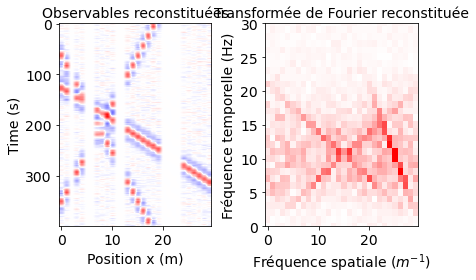

alpha = 0.0001


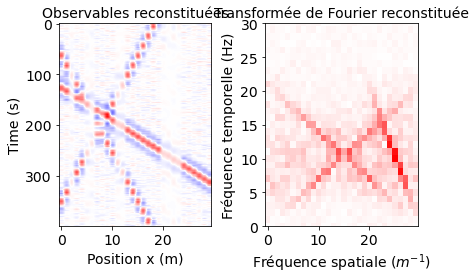

alpha = 0.001


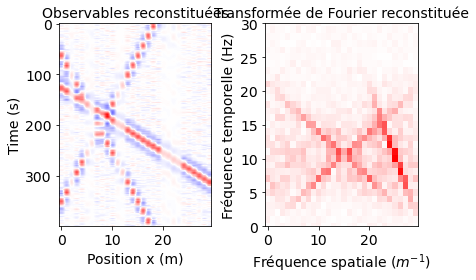

alpha = 0.01


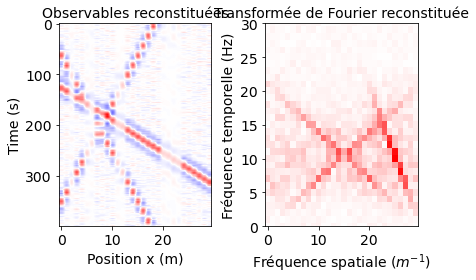

alpha = 0.1


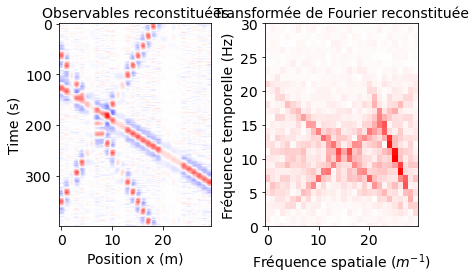

alpha = 1


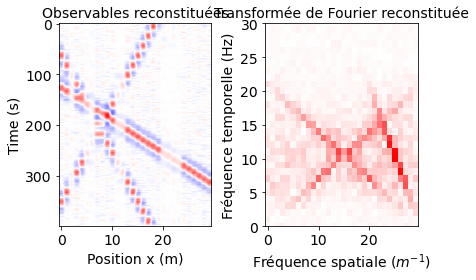

alpha = 10


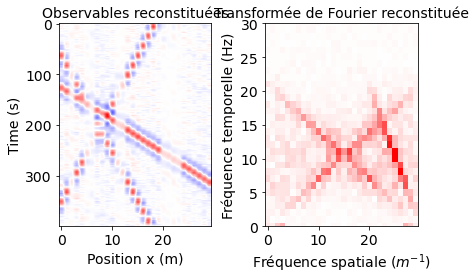

alpha = 100


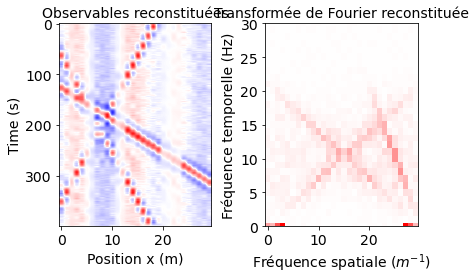

alpha = 1000


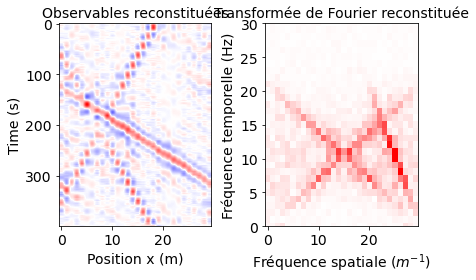

alpha = 10000


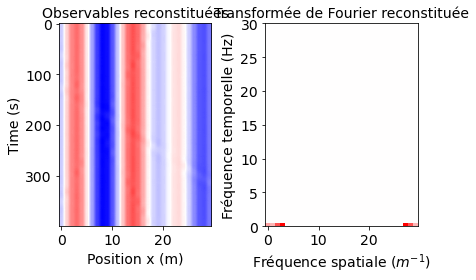

In [34]:
# Iterative mininisation (example)

niter = 10 # number of iterations

#Initialisation
p0 = np.reshape(np.copy(gpanel),nt*nx)

def iteration_alpha(alpha):
    gpanel2 = find_alpha(alpha)
    gpanelf2 = np.abs(np.fft.fft2(gpanel2))
    
    fig = plt.figure()
    vmax = np.max(np.abs(gpanel2))
    
    av = plt.subplot(121)
    plt.imshow(gpanel2,aspect='auto')
    plt.title('Observables reconstituées', fontsize = labelsize)
    av.set_ylabel("Time (s)", fontsize = labelsize)
    av.set_xlabel("Position x (m)", fontsize = labelsize)
    av.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.clim([-vmax,vmax])
    plt.set_cmap('bwr')
    
    vmaxf = np.max(np.abs(gpanelf2))
    
    av2 = plt.subplot(122)
    plt.imshow(gpanelf2,aspect='auto')
    plt.title('Transformée de Fourier reconstituée', fontsize = labelsize)
    av2.set_ylabel("Fréquence temporelle (Hz)", fontsize = labelsize)
    av2.set_xlabel("Fréquence spatiale ($m^{-1}$)", fontsize = labelsize)
    av2.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.clim([-vmaxf,vmaxf])
    plt.ylim(0, 30)
    print(f'alpha = {alpha}')
    fig.tight_layout()
    plt.show()

#On teste plusieurs valeurs de alpha
for i in range(-5, 5):
    iteration_alpha(10**i)

**Observations de la reconstitution d'observables :**

Plus $\alpha$ est grand, plus on est capable de reconstituer les signaux sismiques (les parties linéaires). En revanche, le bruit en-dehors des événements sismiques est plus forts et les droites sont moins marquées.

**Observations des transformées de Fourier :**

Plus $\alpha$ est grand, plus le contraste entre les événements sismiques et le reste est fort. En dehors des droites des observables, l'énergie est quasiment nulle : il y a réduction du bruit. En revanche, l'aliasing spatial est plus visible.

A l'inverse, plus $\alpha$ est faible, moins il y a de recouvrement spectral mais on retrouve beaucoup de bruit et les événements sismiques sont plus difficiles à observer.

**Conclusion**

Il faut donc faire un compromis entre la réduction de bruit et la reconstitution des événements. Une valeur de $\alpha$ comprise entre $10^{-3}$ et $1$ semble adaptée.

# Analyse des Limites des Approches
Proposer une analyse des avantages et limites des approches 1, 2 (et 3 le cas échéant). Tester la robustesse au travers de d'autres applications. Par exemple, vous pouvez :
* Ajouter du bruit (gaussien ou non) sur les données ;
* Avoir des événements linéaires avec des amplitudes différentes ;
* Ajouter des délais en temps pour chaque position en $x$ et comparer les résultats ;
* Rnlever encore plus de données en entrée (plus de traces blanches) ;
* Application sur des images totalement différentes.

**Cette dernière partie est très ouverte, et je fais appel à votre créativité.**

## Perte de données

Enlevons encore plus de données en entrée et observons le résultat.

In [35]:
def blank_panel(index, plot=True):
    """
    Erase data on columns given in the list index.
    """
    gpanel_blank = np.copy(gpanel)
    gpanel_blank[:,index]=0
    if plot:
        vmax = np.max(np.abs(gpanel_blank))
        fig = plt.figure()
        av = plt.subplot(111)
        plt.imshow(gpanel_blank,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
        plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
        av.set_ylabel("Time (s)", fontsize = labelsize)
        av.set_xlabel("Position x (m)", fontsize = labelsize)
        av.tick_params(axis='both', which='major', labelsize=labelsize)
        plt.clim([-vmax,vmax])
        plt.set_cmap('bwr')
    return gpanel_blank, set(mtr+index)    


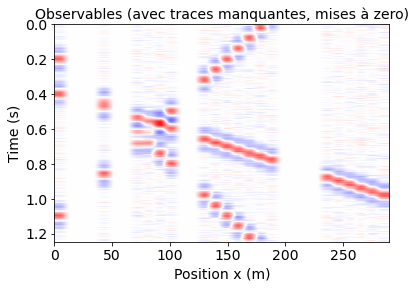

In [36]:
#index=[1,2,3,5,6,7, 28, 29]
index=[1,2,3]
gpanel_blank, mtr_blank = blank_panel(index)

### Approche 1

In [65]:
def approche1(panel, index):
    # échantillons
    nt_samples = 200
    np_samples = 200
    pentes_samples = np.linspace(-1e-2, 1e-2, np_samples)
    time_samples = np.linspace(0, 1.2, nt_samples)

    # fonction F
    x0 = 0
    def F(t, p, x0=x0, gpanel=panel):
        res = 0
        for n in range(nx):
            t_F = t - p*(n*dx - x0)
            #on vérifie que t_F est dans l'intervalle
            if t_F >= 0 and t_F < 1.2:
                res += gpanel[int(t_F/dt), n]*dx
        return res**2
    
    F_array = np.zeros((nt_samples, np_samples))
    for i in range(nt_samples):
        for j in range(np_samples):
            F_array[i, j] = F(time_samples[i], pentes_samples[j], gpanel=panel)

    # uniformisation des zones sombres
    F_array = np.maximum(F_array, 5000)

    # recherche du maximum au sens strict autour du point (i,j) avec une largeur de 20
    def is_maximum(i, j, F_array, length=20):
        max_value = np.max(F_array[max(i-length, 0): min(i+length+1, nt_samples), max(j-length, 0): min(j+length+1, np_samples)])
        min_value = np.min(F_array[max(i-length, 0): min(i+length+1, nt_samples), max(j-length, 0): min(j+length+1, np_samples)])
        return F_array[i, j] == max_value and F_array[i, j] > min_value

    maxima_points = []
    maxima_indices = []
    maxima_values = []
    for ind_t in range(nt_samples):
        for ind_p in range(np_samples):
            if is_maximum(ind_t, ind_p, F_array):
                maxima_points.append((time_samples[ind_t], pentes_samples[ind_p]))
                maxima_values.append(F_array[ind_t, ind_p])
                maxima_indices.append([ind_t, ind_p])
    
    # Reconstitution
    gpanel_reconst = np.copy(panel)
    borne = 30
    for i, m in enumerate(index):
        for j in range(3):
            t, p = maxima_points[j]
            ind_t = round((t - p*m*dx)/dt)
            for eps in range(borne):
                if ind_t + eps < nt and ind_t + eps >= 0:
                    gpanel_reconst[ind_t + eps, m] = panel[min(nt - 1, round(t/dt+eps)), 0]
                if ind_t - eps >= 0 and ind_t - eps < nt:
                    gpanel_reconst[ind_t - eps, m] = panel[max(0, round(t/dt-eps)),0]
                    
    # Affichage
    vmax = np.max(np.abs(gpanel_reconst))
    fig = plt.figure()
    av = plt.subplot(111)
    plt.imshow(gpanel_reconst,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
    plt.title('Observables reconstituées dans le domaine $(x, t)$', fontsize = labelsize)
    av.set_ylabel("Time (s)", fontsize = labelsize)
    av.set_xlabel("Position x (m)", fontsize = labelsize)
    av.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.clim([-vmax,vmax])
    plt.set_cmap('bwr')
    plt.show()


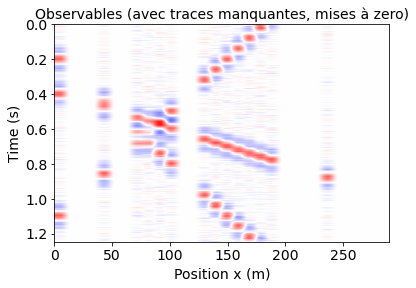

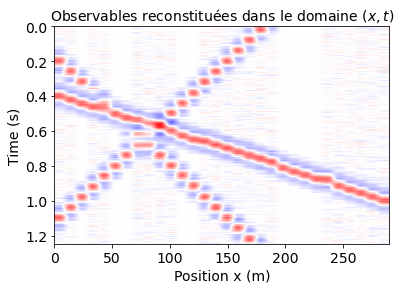

In [68]:
index = [1, 2, 3, 25, 26, 27, 28, 29]
gpanel_blank, mtr_blank = blank_panel(index)
approche1(gpanel, mtr_blank)

Le principe fonctionne toujours si on rajoute des zones blanches, avec les mêmes décalages précédents.

C'est logique puisqu'on retrouve les mêmes valeurs pour les pentes et les ordonnées à l'origine. 

### Approche 2

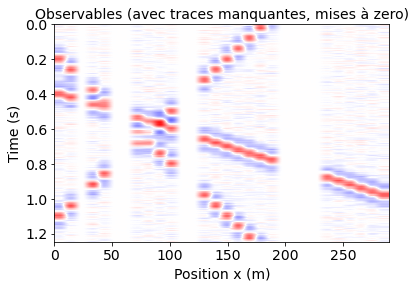

In [41]:
gpanel_blank, mtr_blank = blank_panel(index=[])
gpanel_blankf = np.abs(np.fft.fft2(gpanel))

In [78]:
def approche2(panel):
    pentes = np.linspace(-10, 10, 500)
    gpanelf = np.abs(np.fft.fft2(panel))

    def sommations(pente, gpanelf=gpanelf):
        somme = 0
        #on définit le sens de parcours
        if pente >= 0:
            sens = 1
            x0, t0 = 0, 0
        else:
            sens = -1
            x0, t0 = nx-1, 0
        #on part de (f, kx) = (0,0)
        x, t = x0, t0
        while (x < nx) and (x >= 0) and (t < nt) and (t >= 0):
            somme += gpanelf[t, x]
            x += sens
            t = round(t0 + pente*(x-x0))
        return somme

    sommes = np.vectorize(sommations)(pentes)

    def max_sommations(borne_min, borne_max, sommes=sommes):
        pentes = np.linspace(borne_min, borne_max, 500)
        sommes = np.vectorize(sommations)(pentes)
        indice = np.argmax(sommes)
        return pentes[indice]

    p1 = max_sommations(-10, -2)
    p2 = max_sommations(-2, 0)
    p3 = max_sommations(0, 10)

    def create_masque(gpanelf=gpanelf, pentes=[p1, p2, p3], length=1):
        masque = np.zeros(gpanelf.shape)
        # on réutilise la méthode précédente
        for pente in pentes:
            #on part de (f, kx) = (0,0)
            #on définit le sens de parcours
            if pente >= 0:
                sens = 1
                x0, t0 = 0, 0
            else:
                sens = -1
                x0, t0 = nx-1, 0
            x, t = x0, t0
            # le signal a très peu d'énergie au delà de 20 Hz
            while (x < nx) and (x >= 0) and (t < 20) and (t >= 0):
                # On se place dans un intervalle autour du point considéré
                masque[max(t-length, 0) : min(t+length+1, nt), max(x-length, 0) : min(x+length+1, nx)]= 1
                x += sens
                t = round(t0 + pente*(x-x0))
        return masque
    
    masque = create_masque()

    gpanelff = np.fft.fft2(panel)
    gpanelf_masque = masque * gpanelff
    observables_masque = np.real(np.fft.ifft2(gpanelf_masque))

    vmax = np.max(np.abs(observables_masque))
    fig = plt.figure()
    av = plt.subplot(111)
    plt.imshow(observables_masque, extent=[ax[0],ax[-1],at[-1],at[0]], aspect='auto')
    plt.title('Observables reconstituées à partir du domaine de Fourier - length 1', fontsize = labelsize)
    av.set_ylabel("Time (s)", fontsize = labelsize)
    av.set_xlabel("Position x (m)", fontsize = labelsize)
    av.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.clim([-vmax,vmax])
    plt.set_cmap('bwr')

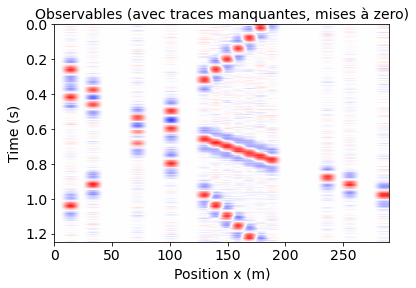

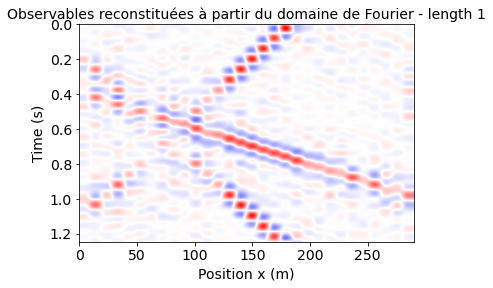

In [86]:
index = [0, 4, 8, 9, 25, 27, 28]
gpanel_blank, mtr_blank = blank_panel(index)
approche2(gpanel_blank)

On retrouve un résultat similaire à précédemment. Les droites sont bien alignées. Mais la perte d'informations donne un rendu moins contrasté et moins lisible donc.

## Application sur des images différentes

L'approche 1 repose sur la linéarité des événements. On se doute donc que la méthode ne fonctionnera pas pour des événements non linéaires.